In [583]:
%load_ext autoreload
%autoreload 2
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import particle as pt
from anytree import Node, RenderTree
from scipy import stats
from scipy.optimize import curve_fit

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.append('/home/henrique/Documents/Atmos_Pandora/apc_atmo_repo/personal/Henrique/')
from ana_tree_class import AnaTreeAnalyzer

plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_theta_phi(dcosx, dcosy, dcosz):
    """ Return theta and phi from versors
    I am keeping the geant output of theta[0, pi] and phi[-pi,pi]
    """
    theta = np.arccos(dcosz)
    if dcosx == 0:
        phi = 0
        if dcosy == 0:
            pass
        elif dcosy > 0:
            phi = np.pi/2
        elif dcosy < 0:
            phi = -np.pi/2
        return theta, phi

    phi = np.arctan(dcosy/dcosx)
    if phi == 0:
        if (dcosx > 0):
            return theta, phi
        else:
            return theta, phi+np.pi
    if phi > 0:
        if dcosx > 0:
            return theta, phi
        else:
            return theta, phi-np.pi
    else: 
        if dcosx > 0:
            return theta, phi
        else:
            return theta, np.pi+phi

In [5]:
tree = uproot.open("./anatree_hd_AV_sum.root:analysistree/anatree")

In [121]:
ana = AnaTreeAnalyzer(file="./anatree_hd_AV_sum.root:analysistree/anatree")
ana.loadTree()

In [122]:
data = ana.data
np.sum(data["inTPCActive_geant"]==1,axis=-1)
# data["geant_list_size_geant"] - data["geant_list_size_in_tpcAV_geant"]

<Array [1437, 134, 111, 116, 403, ..., 3, 173, 161, 62, 3] type='49900 * int64'>

In [123]:
filter_mother = data["Mother_geant"] == 0 
filter_muon = abs(data["pdg_geant"]) == 13
mask_mu = [np.any(val) for val in np.bitwise_and(filter_mother, filter_muon)]
data_with_muons = data[mask_mu]
ana = AnaTreeAnalyzer(data=data)
total_events_with_muon = len(ana.data)
filter_muon = filter_muon.to_list()
muon_as_mother = np.bitwise_and(filter_muon,filter_mother)
list_of_weird_events = []
for i, arr in enumerate(muon_as_mother):
    pos_true = np.asarray(arr).nonzero()
    if np.size(pos_true) and pos_true[0]!=0:
        list_of_weird_events.append(True)
    else:
        list_of_weird_events.append(False)
        

# for ana.ev in ana.data[list_of_weird_events]:
#     ana.create_pdg_ids()
#     ana.make_tree()
#     ana.print_pdg_tree(2,nu_info="ccnc_truth",en="Eng_geant")

# sum(list_of_weird_events)
# set(data[list_of_weird_events]["nuPDG_truth"][:,0].to_list())

# for array in abs(data["genie_primaries_pdg"])==15:
#     print(array)

In [124]:
ana = AnaTreeAnalyzer(data=data)
for i, ana.ev in enumerate(data[0:50]):
    if abs(ana.ev["nuPDG_truth"][0]) == 16:
        print(f'Event:{i+1}')
        ana.make_tree()
        ana.create_pdg_ids()
        ana.print_pdg_tree(4,En="Eng_geant", x="StartPointx_drifted_geant",y="StartPointy_drifted_geant",z="StartPointz_drifted_geant")


Event:10
0:nu(tau) 0.1125 
├── 1:nu(tau) En: 0.0869 x: 0.0475 y: 557.6974 z: 1381.5629 
├── 2:p En: 0.9412 x: 0.0475 y: 557.6974 z: 1381.5629 
├── 3:p En: 0.9462 x: 0.0475 y: 557.6974 z: 1381.5629 
├── 4:p En: 0.9587 x: 0.0475 y: 557.6974 z: 1381.5629 
├── 5:p En: 0.9486 x: 0.0475 y: 557.6974 z: 1381.5629 
├── 6:n En: 0.9424 x: 0.0475 y: 557.6974 z: 1381.5629 
│   ├── 117:gamma En: 0.0022 x: 37.2828 y: 560.4798 z: 1363.0851 
│   ├── 118:n En: 0.9398 x: 37.2828 y: 560.4798 z: 1363.0851 
│   ├── 119:gamma En: 0.0002 x: 37.2828 y: 560.4798 z: 1363.0851 
│   ├── 120:gamma En: 0.0001 x: 37.2828 y: 560.4798 z: 1363.0851 
│   └── 121:Ar40 En: 37.2156 x: 37.2828 y: 560.4798 z: 1363.0851 
├── 7:n En: 0.9443 x: 0.0475 y: 557.6974 z: 1381.5629 
│   ├── 92:gamma En: 0.0038 x: -0.0380 y: 558.8984 z: 1381.6017 
│   ├── 93:n En: 0.9401 x: -0.0380 y: 558.8984 z: 1381.6017 
│   ├── 94:gamma En: 0.0002 x: -0.0380 y: 558.8984 z: 1381.6017 
│   └── 95:Ar40 En: 37.2157 x: -0.0380 y: 558.8984 z: 1381.6017 


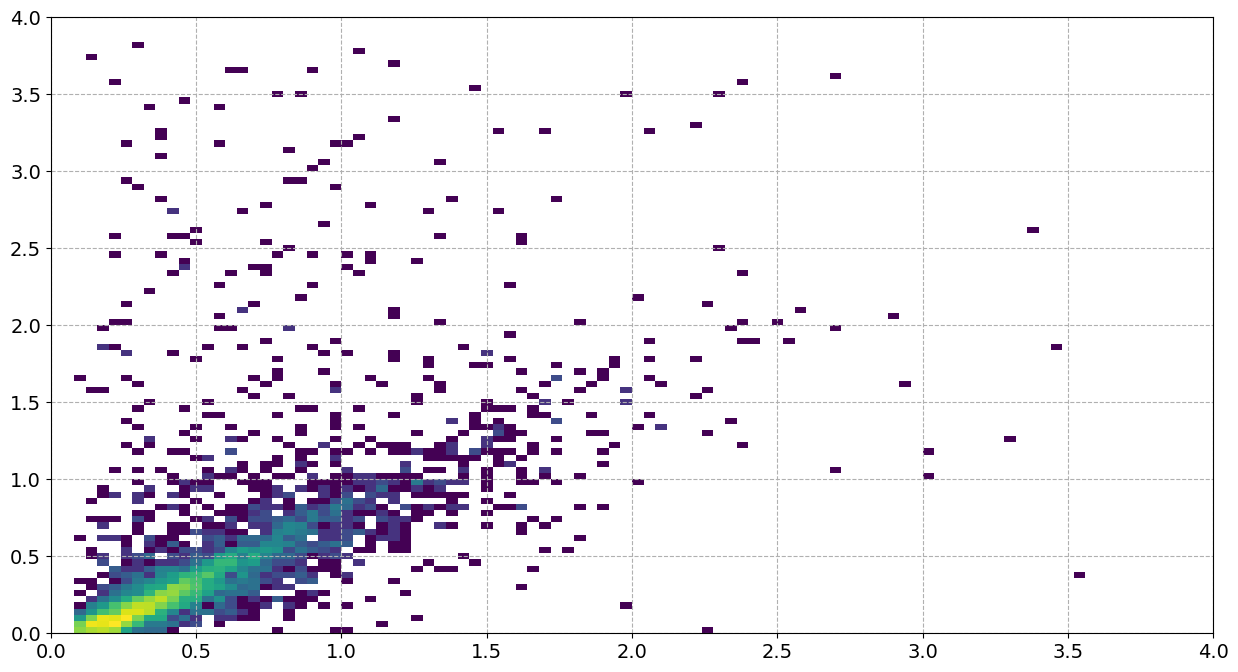

In [632]:
data_cc = data[data["ccnc_truth"][:,0] == 0]
data_noshower = data_cc[data_cc["nshowers_pandoraShower"] == 0]

data_tracks_only = data_noshower[np.any(data_noshower["trkId_pandoraTrack"] >= 0, axis=-1)]
# data_tracks_only = data_noshower[data_noshower["ntracks_pandoraTrack"]!=0] # same but using ntracks

mask_tracks = (data_tracks_only["trkke_pandoraTrack"] > 0)  &\
    (data_tracks_only["trkke_pandoraTrack"] < 1e4) &\
    (abs(data_tracks_only["trkendx_pandoraTrack"]) < 300) &\
    (abs(data_tracks_only["trkendy_pandoraTrack"]) < 500) &\
    (data_tracks_only["trkendz_pandoraTrack"] < 1200) &\
    (data_tracks_only["trkendz_pandoraTrack"] > 50)

tracks_ke = np.sum(np.mean(data_tracks_only["trkke_pandoraTrack"][mask_tracks],axis=-1),axis=-1)

mask_data = tracks_ke>0.0
tracks_ke = tracks_ke[tracks_ke>0.0]*1e-3
nu_en = data_tracks_only["enu_truth"][:,0][mask_data]
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.hist2d(nu_en.to_numpy(), tracks_ke.to_numpy(), bins=100, range=[[0,4],[0,4]],cmin=1, norm='log');

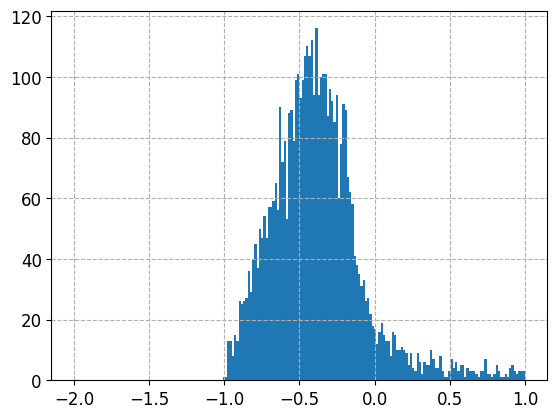

In [250]:
plt.hist(((tracks_ke-nu_en)/nu_en).to_numpy(),bins=200,range=[-2,1]);


In [275]:
def most_frequent(List):
    return max(set(List), key = List.count)

data_only_valid_tracks = data_tracks_only[mask_data]
trk_to_pdg_ids = [[] for _ in data_only_valid_tracks["ntracks_pandoraTrack"]]
for i, val in enumerate(data_only_valid_tracks["trkidtruth_pandoraTrack"]):
    for ids in val:
        ids = ids[ids >= 0j]
        y= ids
        y = most_frequent(ids.to_list())
        trk_to_pdg_ids[i].append(y)
trk_to_pdg_ids = ak.from_regular(trk_to_pdg_ids)


In [276]:
ana.data = data
idx_to_id = ana.idx_to_id_geant(data_only_valid_tracks)

In [627]:
mass_correction = np.zeros_like(tracks_ke.to_numpy())
for i, (trkids, pdg, ev) in enumerate(zip(trk_to_pdg_ids, idx_to_id, data_only_valid_tracks)):
    for trk_pdg_id in trkids:
        if abs(pdg[trk_pdg_id][0]) == 13 and ev["Mother_geant"][pdg[trk_pdg_id][1]] == 0:
            mass_correction[i] = 0.105

    #     print(f'trk associated with pdg code: {pdg[trk_pdg_id][0]}')
    #     print(f'')
    # print(trkids)
    # print(pdg)
    # print('\n')
mass_correction = ak.from_numpy(mass_correction)

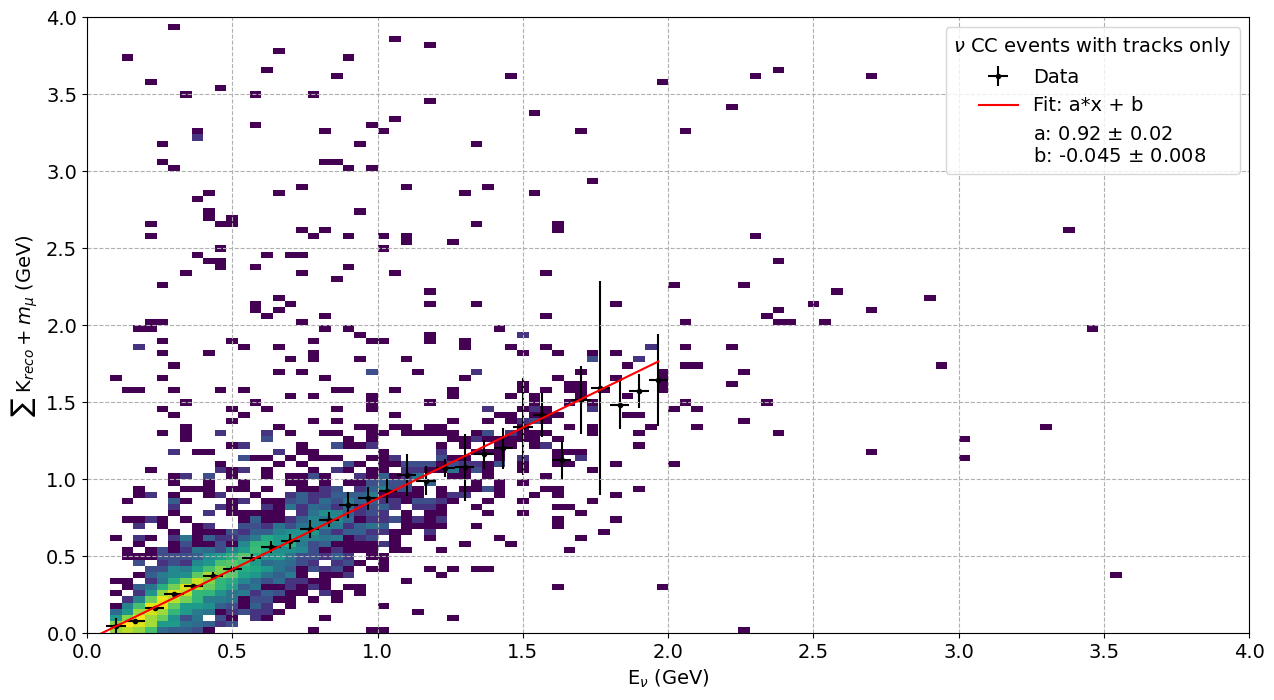

In [629]:
tracks_ke_corrected = (tracks_ke + mass_correction).to_numpy()
nu_en = data_tracks_only["enu_truth"][:,0][mask_data].to_numpy()
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.hist2d(nu_en, tracks_ke_corrected, bins=100, range=[[0,4],[0,4]],cmin=1, norm='log');

nbins=30
nrange=[0,2]
bin_means, bin_edges, binnumber = stats.binned_statistic(nu_en, tracks_ke_corrected, statistic='median', bins=nbins, range=nrange)
bin_stds, bin_edges, binnumber = stats.binned_statistic(nu_en, tracks_ke_corrected, statistic='std', bins=nbins, range=nrange)
bin_counts, bin_edges, binnumber = stats.binned_statistic(nu_en, tracks_ke_corrected, statistic='count', bins=nbins, range=nrange)


bin_center = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1])/2

ax.errorbar(bin_center, bin_means, xerr=(bin_edges[1:]-bin_edges[:-1])/2, yerr=bin_stds/np.sqrt(bin_counts), marker='.', c='k', linestyle='', label='Data', zorder=1)
ax.set_xlabel(r"E$_\nu$ (GeV)")
ax.set_ylabel(r"$\sum$ K$_{reco} + m_\mu$ (GeV)")

def linf(x, m, b):
    return m*x + b

validdata = ~np.isnan(bin_means)
validx = bin_center[validdata]
validy = bin_means[validdata]
validyerr = bin_stds[validdata]/np.sqrt(bin_counts[validdata])
popt, pcov = curve_fit(linf, validx, validy, sigma=validyerr)
perr = np.sqrt(np.diag(pcov))

ax.plot(bin_center, linf(bin_center,*popt),  color='r', label="Fit: a*x + b", zorder=99)
label = ""
parameters = ["a", "b"]
for a, erra, pname in zip(popt,perr, parameters):
    label += f'{pname}: {a:.2} $\pm$ {erra:.2}\n'

label = label[:-2]
fplt = ax.plot([],[],' ', label=label)
ax.legend()
handles, labels = plt.gca().get_legend_handles_labels()
order=[2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=r'$\nu$ CC events with tracks only') 

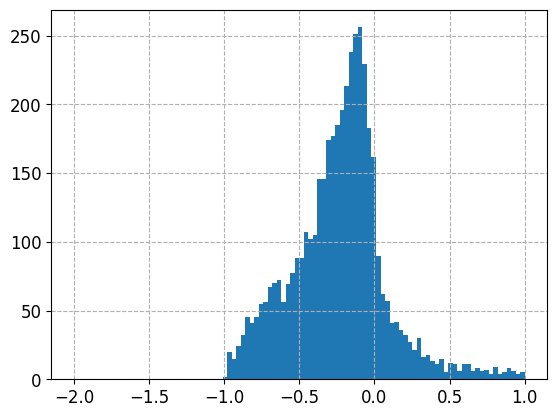

In [382]:
plt.hist(((tracks_ke+mass_correction-nu_en)/nu_en).to_numpy(),bins=100,range=[-2,1]);


/tmp/ipykernel_160837/3840981311.py:33: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend()


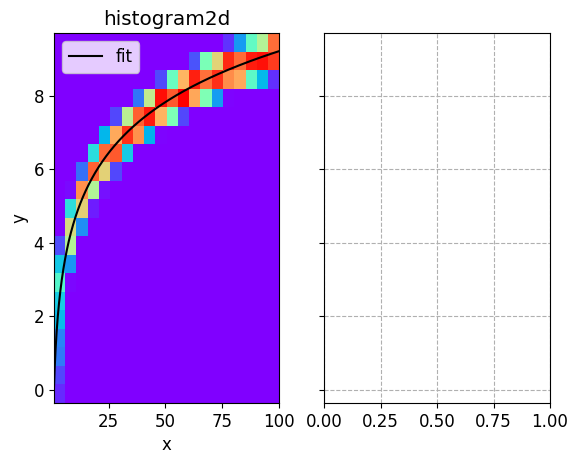

In [506]:
jjjjjjj# Generate non-symmetric test data

n = 10000

x = np.linspace(1, 100, n)

y = 2*np.log(x) + np.random.rand(n) - 0.5

# Compute 2d histogram. Note the order of x/y and xedges/yedges

H, yedges, xedges = np.histogram2d(y, x, bins=20)

# Plot histogram using pcolormesh

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

ax1.pcolormesh(xedges, yedges, H, cmap='rainbow', label='data')


ax1.plot(x, 2*np.log(x), 'k-',label='fit')

ax1.set_xlim(x.min(), x.max())

ax1.set_ylim(y.min(), y.max())

ax1.set_xlabel('x')

ax1.set_ylabel('y')

ax1.set_title('histogram2d')

ax1.grid()
ax1.legend()

name                                     | typename                 | interpretation                
-----------------------------------------+--------------------------+-------------------------------
trkId_pandoraTrack                       | int16_t[]                | AsJagged(AsDtype('>i2'))
trkncosmictags_tagger_pandoraTrack       | int16_t[]                | AsJagged(AsDtype('>i2'))
trkcosmicscore_tagger_pandoraTrack       | float[]                  | AsJagged(AsDtype('>f4'))
trkcosmictype_tagger_pandoraTrack        | int16_t[]                | AsJagged(AsDtype('>i2'))
trkncosmictags_containmenttagger_pand... | int16_t[]                | AsJagged(AsDtype('>i2'))
trkcosmicscore_containmenttagger_pand... | float[]                  | AsJagged(AsDtype('>f4'))
trkcosmictype_containmenttagger_pando... | int16_t[]                | AsJagged(AsDtype('>i2'))
trkncosmictags_flashmatch_pandoraTrack   | int16_t[]                | AsJagged(AsDtype('>i2'))
trkcosmicscore_flashmatch_pandoraTrack